In [1]:
# To be continuef
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import poisson
from tqdm import tqdm

import skimage as ski
from skimage import io

import PIL as pil

from skimage.transform import rescale, resize, downscale_local_mean

from scipy.special import rel_entr

import matplotlib as mpl

# plt.ioff()
plt.ion()

from IPython.display import Image

################ Functions #######################################
from graphsfunctions import *



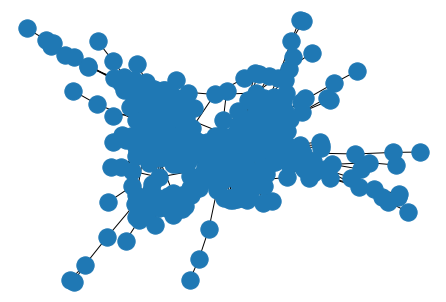

In [2]:
##### Begin Graphing Session
# We import nodes from the yeast interactome which belong to one of 4 groups.
# The rest of the nodes have been discarded. We further narrow down the graph by
# picking up the largest connected component of it. That's what we are going to
# test various clustering methods on.
#We are going to to mark 50% of
# the nodes as 'unknown' and try to recover their group affiliation based on the
# other 50% nodes with known affiliation and the graph structure, using
# different type of methods: 
# 1) propagating from the known node and assigning it to the group that has the
# largest probability based on that propagation.
# 2) same as 1 but we first order (top down) the nodes by pageRank. We determine
# the hooter nodes first and update the list of known nodes on the fly.
# 3) Using a simple plurality decision among the known neighbors of each node.
# 4) same as 3 but again first ordering the nodes and updating known nodes on
# the fly.
# 5) propagating from each of the groups to the unknown nodes, so each unknown
# node will be assigned the group that propagate the highest value onto it.

G = nx.read_graphml('yeast_4_groups.graphml')   # watch out keyerror 'long' bug.
                                                # edit source file change long
                                                # to int

G=nx.convert_node_labels_to_integers(G)

G.nodes[0]['Group']

G = nx.to_networkx_graph(G)

G

ccs = nx.connected_components(G)

ccs

largest_cc = max(nx.connected_components(G), key=len)

S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

S

G = G.subgraph(largest_cc).copy()

G.nodes()

G = nx.convert_node_labels_to_integers(G)

G.nodes()

nx.draw_spring(G)


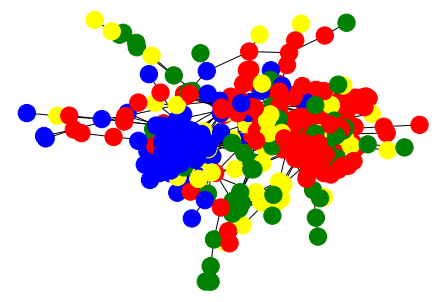

In [3]:
groups = [G.nodes[x]['Group'] for x in G.nodes()]

groups

groups = np.array(groups) #array is better than a simple list ...

# color code the groups
color_code_dict = dict(zip(np.unique(groups), ['blue', 'red', 'yellow', 'green']))
color_code_dict

# assign color based on group affiliation
node_colors = [color_code_dict[k] for k in groups]

group_labeling = np.unique(groups)
nx.draw_spring(G, node_color=node_colors, label=group_labeling)

#nx.draw_spring(G, node_color=node_colors)



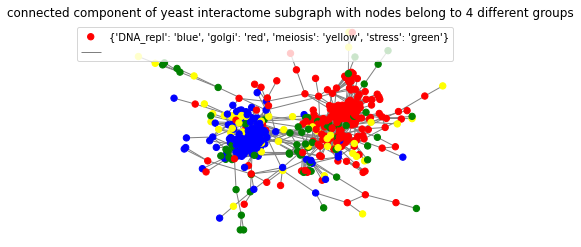

In [4]:
mypos=nx.spring_layout(G)
plt.figure(1)
plt.title(
    'connected component of yeast interactome subgraph with nodes belong to 4 different groups'
    )
nx.draw(G, pos=mypos, node_color=node_colors, node_size=40,
         edge_color='gray')
plt.legend(labels=[str(color_code_dict),''])



#plt.savefig(
#    'connected component of yeast interactome subgraph with nodes belong to 4 different groups.png'
#)
#plt.close()


In [7]:
len(G.nodes)
len(node_colors)

# The plan: keep 50% of members of each group with their known assignment. The
# Rest of the nodes are going to be 'unknow'. Run the decision algorithm on the
# unkown members, assign each of them the likelies group and test for correction
# while doing that. keep track of the true/false score. plots...

df = pd.DataFrame()

df['Group'] = groups

df

dfg = pd.read_csv('yeast_4g_table.csv', header=0)

scores = np.zeros((2,5))

# randomly select 50% and mark them as 'unkown'
np.random.seed(seed=42) #scores[0][*]

#np.random.seed(seed=6382020) #scores[1][*]

known_unknown = np.random.random(len(G.nodes)) > 0.5

df['Known'] = known_unknown # True if group membership is known

#df['Group'][randomnumbers]

all_nodes = np.arange(len(G.nodes))

known_nodes = all_nodes[known_unknown]

unkown_nodes = all_nodes[known_unknown == False]

print(known_nodes)

print(unkown_nodes)


[  1   2   3   7   8   9  11  12  17  20  25  27  28  30  33  34  35  38
  43  45  47  48  50  51  52  53  54  55  62  65  67  69  70  73  74  75
  76  80  81  86  87  88  91  92  93  94  96 101 103 104 107 112 113 114
 115 116 118 119 120 121 126 127 129 134 136 137 139 140 146 147 150 154
 156 157 159 161 162 163 165 169 170 172 174 176 178 182 183 185 186 187
 188 191 192 193 196 197 198 199 200 203 204 207 210 211 212 214 217 218
 219 220 221 226 228 229 230 231 232 235 238 240 241 242 245 247 248 249
 252 255 256 257 258 260 261 263 264 265 266 267 270 271 272 273 274 275
 276 277 278 279 280 284 287 289 292 295 296 298 301 302 303 304 305 306
 308 313 314 315 320 321 322 324 325 326 327 331 336 337 345 346 349 350
 351 352 355 357 358 359 361 363 364 366 367 373 376 378 381 382 383 384
 385 388 389 390 393 395 396 398 399 401 402 403 405 408 411 412 413 414
 418 419 420 421 425 427 431 432 435 437 438 441 444 445 446 447 450 451
 453 461 462 463 464 467 469 471 473 474 475 477 47

In [8]:
def decision_function(v, G, group_membership_ar, known_unknown_ar):
    """Input v: an node assumed to be an int and taken from the list of unkown
    nodes. Input G: The graph. 
    Input group_membership_ar: Array of strings which specifies for each node 
    to which group belongs (including the 'unkonw' nodes) this is required for
    thesting the correctness of the decision.
    Input known_unknown_ar: boolean 1d array which
    specifies for each node of the graph whether its membership is known or
    unkown. 
    output guess_group: string the group that the function assigns the node to.
    output correctness: True or false depending on the correctness of the
    guess_group vs the real group_membership_list[v] value.
    """
    all_nodes = np.arange(len(G.nodes))
    known_nodes = all_nodes[known_unknown_ar]
    unkown_nodes = all_nodes[known_unknown_ar == False]
    bias = np.zeros_like(G.nodes)
    bias[v] = 1
    bias
    p = biasedPropagateGv2(G, bias=bias)
    group_names = np.unique(group_membership_ar)
    q = p * known_unknown_ar #0 on all unkown nodes
    testscores = np.zeros_like(group_names)
    for g in range(len(group_names)):
        x = q[group_membership_ar == group_names[g]] 
        testscores[g] = x.sum()
    decide = group_names[np.argmax(testscores)]
    correctness = decide == group_membership_ar[v]
    return decide, correctness


In [9]:
# We repeat this twice, with 2 different seeds (see above)
known_unknown1 = known_unknown.copy()
score1 = 0
for v in unkown_nodes:
    _, test = decision_function(v, G, groups, known_unknown1)
    score1 += test
    #known_unknown1[v] = True
    #print(test)

score1 = score1 / len(unkown_nodes) #got 0.79
score1

scores[0][0] = score1 #seed=42

#scores[1][0] = score1 #seed=6382020


In [10]:
print(score1)

0.7947761194029851


In [11]:
# Now we use the pageRank to determine the order in which we run over the unkown nodes.
# higher pageranked nodes come first. Their predicted value is inserted into the list 
# known nodes and used in the follwing predictions. The reason is, we think the higher 
# ranked nodes can be more accurately predicted by virtue of being well connected and 
# they hopefully are still well connected to nodes with known function and that reflects
# their affilication.

pageRank = biasedPropagateGv2(G, np.ones_like(G.nodes))

orderedNodeList = np.argsort(pageRank)

orderedUnkownNodeList = orderedNodeList[known_unknown == False]


In [12]:
G2 = G.copy()
for v in G2.nodes():
    G2.nodes[v]['correctness2'] = "Known"

known_unknown2 = known_unknown.copy()
node_colors2 = node_colors.copy()
score2 = 0
for v in orderedUnkownNodeList:
    _, test = decision_function(v, G, groups, known_unknown2)
    score2 += test
    known_unknown2[v] = True #mark v as 'known'
    G2.nodes[v]['correctness2'] = "Correct"
    node_colors2[v] = 'brown'
    if not test: # mark as incorrect and colormark if mistake
        node_colors2[v] = 'pink'
        G2.nodes[v]['correctness2'] = "Mistake"
    #print(test)

score2 = score2 / len(unkown_nodes) #got 0.85
print(score2)

scores[0][1] = score2 #seed=42

#scores[1][1] = score2 #seed=6382020


0.8582089552238806


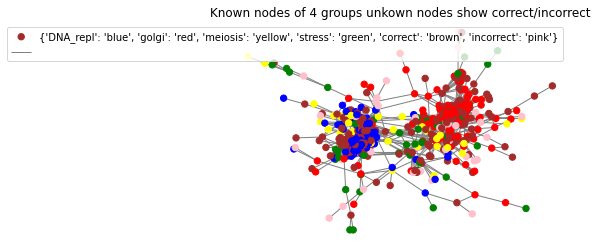

In [13]:
# We now plot the results of method2 which was the best perfoming method:

extended_color_code = color_code_dict.copy()
extended_color_code['correct'] = 'brown'
extended_color_code['incorrect'] = 'pink'
extended_color_code

plt.figure(1)
plt.title(
    'Known nodes of 4 groups unkown nodes show correct/incorrect'
    )
nx.draw(G2, node_color=node_colors2, node_size=40,
        edge_color='gray', pos=mypos)
# the rational: I think determining the hotter unkown nodes first makes sense as
# their determination is probably easier. Then we use them for the following
# rounds.

plt.legend(labels=[str(extended_color_code),''])


In [14]:
# I need to compare this mechanism to decision by neighbors.

def simple_decision_by_neighbors(v, G, group_membership_ar, known_unknown_ar):
    """This decision function assign to v to the biggest group by members among
    its neighbors with known affiliation.
    """
    all_nodes = np.arange(len(G.nodes))
    known_nodes = all_nodes[known_unknown_ar]
    unkown_nodes = all_nodes[known_unknown_ar== False]
    group_names = np.unique(group_membership_ar)
    testscores = np.zeros_like(group_names)
    for g in range(len(group_names)):
        l = [x for x in G.neighbors(v) if x in known_nodes and group_membership_ar[x] == group_names[g]]
        testscores[g] = len(l)
    decide = group_names[np.argmax(testscores)]
    correctness = decide == group_membership_ar[v]
    return decide, correctness


known_unknown3 = known_unknown.copy()
score3 = 0
for v in unkown_nodes:
    _, test = simple_decision_by_neighbors(v, G, groups, known_unknown3)
    score3 += test
    #known_unknown3[v] = True
    #print(test)

score3 = score3 / len(unkown_nodes) #got 0.79
print(score3)

scores[0][2] = score3 #seed=42

#scores[1][2] = score3 #seed=6382020


0.7649253731343284


In [15]:
known_unknown4 = known_unknown.copy()
score4 = 0
for v in orderedUnkownNodeList:
    _, test = simple_decision_by_neighbors(v, G, groups, known_unknown4)
    score4 += test
    known_unknown4[v] = True
    #print(test)

score4 = score4 / len(unkown_nodes) #got 0.76
print(score4)

scores[0][3] = score4 #seed=42

#scores[1][3] = score4 #seed=6382020


0.7835820895522388


In [16]:
# Finally for the 5th run we try another propagation method. This time we propagate 
# from the groups of known function to the unknown nodes. We predict the function of an 
# unknown node as the group which progagates the highest value to it.

In [17]:
def decision_by_known_groups(G, group_membership_ar, known_unknown_ar):
    """
    Input G: Graph
    Input group_membership_ar: 1d array of strings which designate to which
    group each node belongs to for all nodes.
    Input known_unknown_ar: Boolean array which designate for each node, for the
    simmulation purpose, whether its group assignment is known or unkown.
    The function will propagate from each group type among the known nodes.
    Meaning it calculates the stationary distribution with restart on the know
    nodes which belong to group "X" and repeat that for all groups.
    """
    all_nodes = np.arange(len(G.nodes))
    known_nodes = all_nodes[known_unknown_ar]
    unkown_nodes = all_nodes[known_unknown_ar == False]
    group_names = np.unique(group_membership_ar)
    biases = np.zeros((len(group_names),len(known_unknown_ar)))
    results = np.zeros_like(biases)
    for g in range(len(group_names)):
        x = group_membership_ar == group_names[g]
        biases[g] = x * known_unknown_ar
        results[g] = biasedPropagateGv2(G, bias=biases[g])
    decision = np.argmax(results, axis=0)
    decision = [group_names[x] for x in decision]
    decision = np.array(decision)
    test = decision == group_membership_ar
    test = test[unkown_nodes]
    score = test.sum() / len(test)
    return results, decision, score

x,y,score5 = decision_by_known_groups(G, groups, known_unknown) #got 0.70

print(score5)

scores[0][4] = score5 #seed=42

#scores[1][4] = score5 #seed=6382020


0.7014925373134329


[[0.79477612 0.85820896 0.76492537 0.78358209 0.70149254]
 [0.         0.         0.         0.         0.        ]]


<BarContainer object of 5 artists>

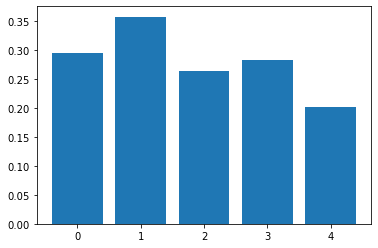

In [18]:
print(scores)

mycolumns=['seed', 'method1' , 'method2', 'method3',
    'method4', 'method5']

scoreDF = pd.DataFrame(columns=mycolumns)

scoreDF['seed'] = [42, 6382020]

scoreDF[mycolumns[1:]] = scores

#scoreDF.to_csv('methods_scores.tsv', sep='\t', header=True, index=False)

plt.bar(range(5), scores[0]-0.5)
